In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes
from pfhedge.instruments import BrownianStock

from pfhedge.instruments import EuropeanOption
from pfhedge.nn.modules.mlp import MultiLayerPerceptron
import pfhedge.nn.modules.datahedger as datahedger
from pfhedge.nn.modules.loss import ExpectedShortfall
from importlib import reload
reload(datahedger)

def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

def plot_pnl(pnl):
    plt.figure()
    plt.hist(to_numpy(pnl), bins=100)
    
    plt.title("Profit-loss histograms of 50000 price paths for a European option")
    plt.xlabel("Profit-loss")
    plt.ylabel("Number of events")
    plt.grid()
    plt.show()


### Single trading asset

In [10]:
N_EPOCHS = 200
N_PATHS = 50000

s0 = 1.
dt = 1/365
maturity = 30/365
time_steps = ceil(maturity / dt)

derivative = EuropeanOption(BrownianStock(dt=dt), strike = s0, maturity=maturity)
derivative.simulate(N_PATHS, init_state= s0)

prices = derivative.underlier.spot[...,None]
payoff = derivative.payoff_fn()[:,None]

time_to_maturity = torch.linspace(maturity, 0, time_steps + 1)
time_to_maturity = torch.tile(time_to_maturity, [N_PATHS,1])[...,None]

information = torch.cat([
    torch.log(prices),
    time_to_maturity
    ], axis = -1)

n_asset = prices.shape[-1]
data_set = [prices, information, payoff]
dataset_market = datahedger.MarketDataset(data_set)


In [11]:
model = BlackScholes(derivative)
hedger = Hedger(model, inputs=model.inputs())
hedger.price(derivative, init_state=s0)


tensor(0.0228)

### Data Hedger

In [12]:
model = MultiLayerPerceptron(out_features = n_asset)
hedger = datahedger.DataHedger(model, dataset_market) 
hedger.fit(10)     

Loss=0.023119883611798286: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


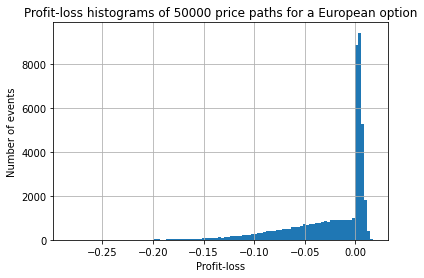

Option price is  [0.02369387]


In [13]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_pnl(pnl)
print('Option price is ', price)


### Deep Hedger

In [14]:
# models = [MultiLayerPerceptron(out_features = n_asset) for t in range(time_steps)]
# hedger = datahedger.DeepHedger(models, dataset_market, ExpectedShortfall()) 
hedger.fit(100)  

Loss=0.02341233380138874: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


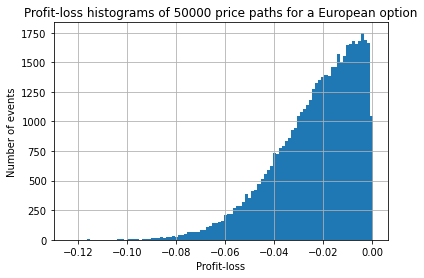

Option price is  [0.02369387]


In [15]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_pnl(pnl)
print('Option price is ', price)


### Heston Model

In [27]:
from pfhedge.instruments import EuropeanOption
from pfhedge.instruments import HestonStock
from pfhedge.instruments import VarianceSwap
from pfhedge.nn import MultiLayerPerceptron

kappa = 1.
theta = 0.04
sigma = 2.
rho = -0.7
v0 = 0.04
s0 = 100.
init_state = (s0,v0)

dt = 1/365
maturity = 30/365

N_EPOCHS = 200
N_PATHS = 50000

derivative = EuropeanOption(HestonStock(kappa = kappa, theta = theta, sigma = sigma, rho = rho, dt = dt), strike = s0, maturity=maturity)
stock = derivative.underlier
derivative.simulate(N_PATHS, init_state=init_state)

time_steps = ceil(maturity / dt)
time_to_maturity = torch.linspace(maturity, 0, time_steps + 1)
time_to_maturity = torch.tile(time_to_maturity, [N_PATHS,1])[...,None]

payoff = derivative.payoff_fn()[:,None]
varswap = VarianceSwap(stock, strike = 0.0)
prices_heston = stock.spot[...,None]
variance_heston = stock.variance[...,None]

L_func = lambda tau,v: (v-theta) / kappa * (1-(-kappa*(tau)).exp()) + theta*tau
prices_varswap = torch.cumsum(variance_heston,dim=-1) * stock.dt + L_func(time_to_maturity, variance_heston)

prices = torch.Tensor(torch.cat([prices_heston, prices_varswap],axis = -1))
n_asset = prices.shape[-1]

information = torch.cat([
    torch.log(prices_heston),
    variance_heston,
    time_to_maturity
    ], axis = -1)

data_set = [prices, information, payoff]

dataset_market = datahedger.MarketDataset(data_set)


### Data hedge

In [17]:
model = MultiLayerPerceptron(out_features = n_asset)
hedger = datahedger.DataHedger(model, dataset_market) 
hedger.fit(100)     

Loss=9.167202949523926: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


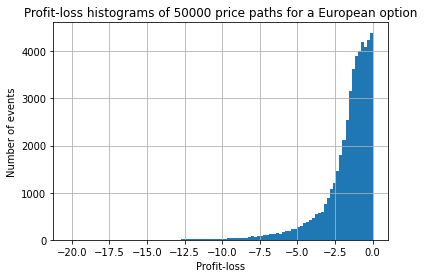

Option price is  [10.188822]


In [18]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_pnl(pnl)
print('Option price is ', price)    

### Deep hedger

In [1]:
d = n_asset
models = [MultiLayerPerceptron(layer = 2, units = (d+15,d+15), out_features = d) for t in range(time_steps)]
hedger = datahedger.DeepHedger(models, dataset_market, ExpectedShortfall(p = 0.5)) 
hedger.fit(100)  


NameError: name 'n_asset' is not defined

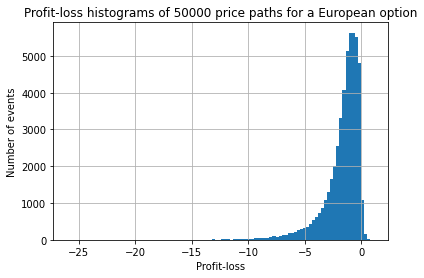

Option price is  [2.7613318]


In [20]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_pnl(pnl)
print('Option price is ', price)    